In [2]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision import datasets, transforms
import argparse


from torchviz import make_dot, make_dot_from_trace

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

###  Build Network

In [10]:
class Net( nn.Module ):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d( 1, 32, 3, 1)
        self.conv2 = nn.Conv2d( 32, 64, 3, 1)
        
        self.dropout1 = nn.Dropout2d( 0.25 )
        self.dropout2 = nn.Dropout2d( 0.25 )
        
        self.fc1 = nn.Linear( 788544, 128 )
        self.fc2 = nn.Linear( 128, 10 )
        
    def forward( self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = F.max_pool2d( x, 2 )
        x = self.dropout1(x)
        x = torch.flatten( x, 1)
        x = self.fc1(x)
        x= F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        output = F.log_softmax( x, dim =1 )
        
        return output

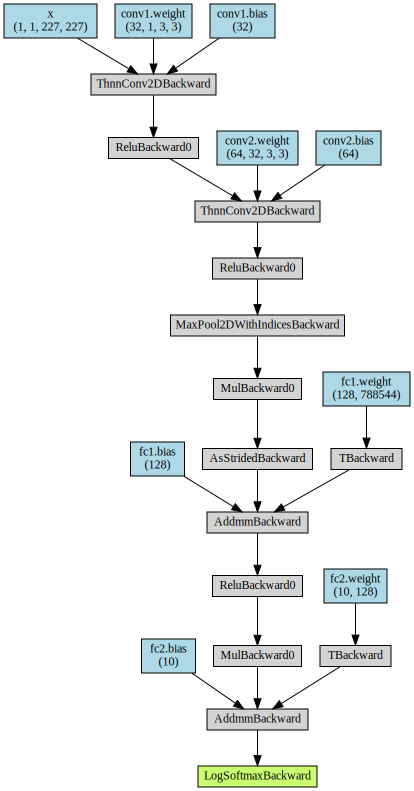

In [11]:
model = Net()

x = torch.randn(1, 1, 227, 227).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

### Training

In [12]:
def train( args, model, device, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate( train_loader):
        data, target  = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss( output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### Testing

In [13]:
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            test_loss += F.nll_loss( output, target, reduction = 'sum').item()
            
            pred = output.argmax( dim = 1, keepdim = True )
            
            correct  += pred.eq( target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Main Function

In [26]:
def main():
    
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N', required= False,
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N', required= False,
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N', required= False,
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR', required= False,
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M', required= False,
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--seed', type=int, default=1, metavar='S', required= False,
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N', required= False,
                        help='how many batches to wait before logging training status')

   
    args = parser.parse_args()
    parser.add_argument('-f')

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    
    train_loader = torch.utils.data.DataLoader( datasets.MNIST( '../data', 
                                                              train = True, 
                                                              download = True, 
                                                              transform = transforms.Compose([
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.1307,), (0.3081,))
                                                              ])),
                                              batch_size = args.test_batch_size,
                                              shuffle = True,
                                              **kwargs)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', 
                       train=False, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    model = Net().to(device)
    
    optimizer = optim.AdaDelta( model.parameters(), lr =args.lr)
    
    scheduler = StepLR( optimizer, step_size = 1,  gamma = args.gamma)
    
    for epoch in range(1, args.epochs + 1):
        train( args, model, device, train_loader, optimizer, epoch)
        
        test( model, device, test_loader )
        
        scheduler.step()
        
  
        
    

### Running All

In [ ]:
if __name__ == '__main__':
    main()